# REDES NEURONALES

Para la elaboracion de los modelos de Redes Neuronales, se debe comenzar destacando que se ha necesitado hacer uso de la herramienta de google colab, ya que nos permitia una obtencion de resultados en un menor tiempo.

## ÍNDICE

* [1. Preparacion de los datos](#1)
* [2. Division de los datos mediante la funcion SPLIT](#2)
* [3. Escalado o Normalización](#3)
* [4. Red Neuronal Densa (DNN)](#4)
 * [4.1 Modelo](#4.1)
 * [4.2 Predicciones](#4.2)
* [5. Redes Neuronales LSTM](#5)
 * [5.1 Modelo](#5.1)
 * [5.2 Predicciones](#5.2)
* [6. Redes Neuronales Convolucionales](#6)
 * [6.1 Modelo](#6.1)
 * [6.2 Predicciones](#6.2)

### Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


### Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [130]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [131]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.625813874999949
GPU (s):
0.1777735030009353
GPU speedup over CPU: 20x


## 1. Preparación de los datos
<a id="1"></a>

In [132]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns; sns.set()

In [133]:
from datetime import datetime
def fechas(x):
    x = datetime.strptime(x, '%m-%d-%Y %I:%M %p')
    return x

In [134]:
patient_0_RN = pd.read_csv('patient0.csv')
patient_0_RN.dropna(inplace = True)
patient_0_RN.reset_index(drop=True, inplace=True)
patient_0_RN.head()

patient_0_RN['DATES'] = patient_0_RN['DATE'].apply(fechas)
patient_0_RN.drop('DATE', axis = 1, inplace = True)
patient_0_RN.head()

patient_0_RN.rename(columns={' LEVEL':'LEVEL'}, inplace=True)

patient_0_RN.sort_values('DATES', ascending=True, inplace=True)

patient_0_RN.head()

,LEVEL,DATES
85599,194.0,2016-08-24 15:20:00
85600,164.0,2016-08-24 15:35:00
85601,126.0,2016-08-24 15:50:00
85602,87.0,2016-08-24 16:05:00
85603,65.0,2016-08-24 16:20:00


Text(0.5, 1.0, 'Box plot of Glucosa')

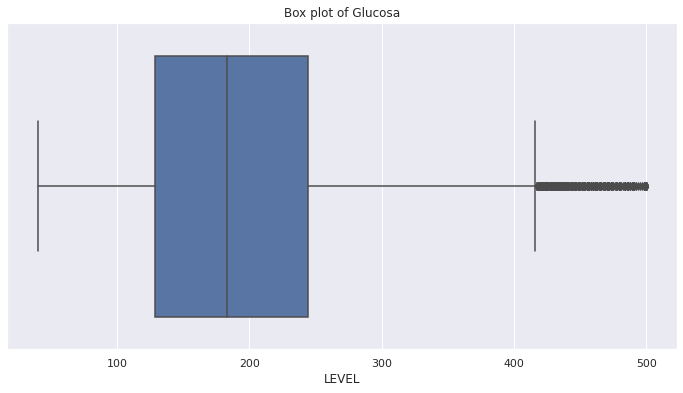

In [135]:
#Let us draw a box plot to visualize the central tendency and dispersion of LEVEL
plt.figure(figsize=(12, 6))
g = sns.boxplot(patient_0_RN['LEVEL'])
g.set_title('Box plot of Glucosa')

## 2. División de los datos mediante la funcion SPLIT
<a id="2"></a>


In [136]:
import datetime
split_date = datetime.datetime(year=2018, month=8, day=1)
df_train  = patient_0_RN.loc[patient_0_RN['DATES']<split_date]
df_test = patient_0_RN.loc[patient_0_RN['DATES']>=split_date]
print('Shape of train:', df_train.shape)
print('Shape of test:', df_test.shape)

Shape of train: (75294, 2)
Shape of test: (18363, 2)


In [137]:
df_train = df_train.set_index('DATES')
df_test = df_test.set_index('DATES')

In [138]:
df_train.sort_values('DATES', ascending=True, inplace=True)
df_test.sort_values('DATES', ascending=True, inplace=True)

#Reset the indices of the validation set
df_train.reset_index(drop=True, inplace=True)

#Reset the indices of the validation set
df_test.reset_index(drop=True, inplace=True)

**Defunimos la funcion**

In [139]:
from math import ceil
def split(data, x_size, y_size, gap, overlap):
    assert overlap < x_size
    size = data.shape[0]
    n_bloques = ceil((size + 1 - y_size - x_size - gap) / (x_size - overlap))

    X = np.empty((n_bloques,x_size))
    y = np.empty((n_bloques,y_size))

    for i in range(n_bloques):
        X[i,:] = (
            data[(i * (x_size - overlap)): 
                     i * (x_size - overlap) + x_size]
        )        
        y[i,:] = (
            data[i * (x_size - overlap) + x_size + gap:
                    i * (x_size - overlap) + x_size + gap + y_size]
        )
    return(np.array(X), np.array(y))

### Division diaria de los datos

In [140]:
x_window_size_diaria = int(24*60*1/15) #NUMERO DE OBSERVACIONES EN 1 DIA
gap = 1
y_window_size_diaria = 1
X_train_diaria, y_train_diaria  = split(df_train.LEVEL, x_size=x_window_size_diaria, y_size=y_window_size_diaria, gap=gap, overlap=x_window_size_diaria-1)
X_test_diaria, y_test_diaria = split(df_test.LEVEL, x_size=x_window_size_diaria, y_size=y_window_size_diaria, gap=gap, overlap=x_window_size_diaria-1)

In [141]:
print('Shape of train arrays:', X_train_diaria.shape, y_train_diaria.shape)
print('Shape of validation arrays:', X_test_diaria.shape, y_test_diaria.shape) 

Shape of train arrays: (75197, 96) (75197, 1)
Shape of validation arrays: (18266, 96) (18266, 1)


### Division semanal de los datos

In [142]:
x_window_size_semanal = int(24*60*7/15)
gap = 1
y_window_size_semanal = 1
X_train_semanal, y_train_semanal = split(df_train.LEVEL, x_size=x_window_size_semanal, y_size=y_window_size_semanal, gap=gap, overlap=x_window_size_semanal-1)
X_test_semanal, y_test_semanal = split(df_test.LEVEL, x_size=x_window_size_semanal, y_size=y_window_size_semanal, gap=gap, overlap=x_window_size_semanal-1)

In [143]:
print('Shape of train arrays:', X_train_semanal.shape, y_train_semanal.shape)
print('Shape of validation arrays:', X_test_semanal.shape, y_test_semanal.shape) 

Shape of train arrays: (74621, 672) (74621, 1)
Shape of validation arrays: (17690, 672) (17690, 1)


### Division mensual de los datos

In [144]:
x_window_size_mensual = int(24*60*30/15)
gap = 1
y_window_size_mensual = 1
X_train_mensual, y_train_mensual = split(df_train.LEVEL, x_size=x_window_size_mensual, y_size=y_window_size_mensual, gap=gap, overlap=x_window_size_mensual-1)
X_test_mensual, y_test_mensual = split(df_test.LEVEL, x_size=x_window_size_mensual, y_size=y_window_size_mensual, gap=gap, overlap=x_window_size_mensual-1)

In [145]:
print('Shape of train arrays:', X_train_mensual.shape, y_train_mensual.shape)
print('Shape of validation arrays:', X_test_mensual.shape, y_test_mensual.shape)

Shape of train arrays: (72413, 2880) (72413, 1)
Shape of validation arrays: (15482, 2880) (15482, 1)


## 3. Escalado o Normalización
<a id="3"></a>

Es necesario llevar a cabo un escalado de los datos con los cuales se van a entrenar los modelo de las diferentes redes neuronales. Por este motivo como se han llevado a cabo diferentes divisiones de datos, tendremos que realizarlo una a una. Por este motivo para la normalizacion de cada bloque sera necesario restar a cada valor la media del bloque y dividirlo por la desviacion tipica de su respectivo bloque.

### TRAIN

**DIARIO**

In [146]:
#Vector con las medias de los bloques
vect_medias_diaria = np.mean(X_train_diaria, axis = 1)
#Vector con la desv. tip. de los bloques
vect_desvt_diaria = np.std(X_train_diaria, axis = 1)

**SEMANAL**

In [147]:
#Vector con las medias de los bloques
vect_medias_semanal = np.mean(X_train_semanal, axis = 1)
#Vector con la desv. tip. de los bloques
vect_desvt_semanal = np.std(X_train_semanal, axis = 1)

**MENSUAL**

In [148]:
#Vector con las medias de los bloques
vect_medias_mensual = np.mean(X_train_mensual, axis = 1)
#Vector con la desv. tip. de los bloques
vect_desvt_mensual = np.std(X_train_mensual, axis = 1)

### Definimos el escalado

**DIARIO**

In [149]:
X_train_scaled_diaria = np.empty((X_train_diaria.shape[0],X_train_diaria.shape[1]))
y_train_scaled_diaria = np.empty((y_train_diaria.shape[0],y_train_diaria.shape[1]))
for i in range(X_train_diaria.shape[0]):
    X_train_scaled_diaria[i,:] = (
        (X_train_diaria[i,:]-vect_medias_diaria[i])/vect_desvt_diaria[i]
    )
    
    y_train_scaled_diaria[i,:] = (
        (y_train_diaria[i,:]-vect_medias_diaria[i])/vect_desvt_diaria[i]
    )

**SEMANAL**

In [150]:
X_train_scaled_semanal = np.empty((X_train_semanal.shape[0],X_train_semanal.shape[1]))
y_train_scaled_semanal = np.empty((y_train_semanal.shape[0],y_train_semanal.shape[1]))
for i in range(X_train_semanal.shape[0]):
    X_train_scaled_semanal[i,:] = (
        (X_train_semanal[i,:]-vect_medias_semanal[i])/vect_desvt_semanal[i]
    )
    
    y_train_scaled_semanal[i,:] = (
        (y_train_semanal[i,:]-vect_medias_semanal[i])/vect_desvt_semanal[i]
    )

**MENSUAL**

In [151]:
X_train_scaled_mensual = np.empty((X_train_mensual.shape[0],X_train_mensual.shape[1]))
y_train_scaled_mensual = np.empty((y_train_mensual.shape[0],y_train_mensual.shape[1]))
for i in range(X_train_mensual.shape[0]):
    X_train_scaled_mensual[i,:] = (
        (X_train_mensual[i,:]-vect_medias_mensual[i])/vect_desvt_mensual[i]
    )
    
    y_train_scaled_mensual[i,:] = (
        (y_train_mensual[i,:]-vect_medias_mensual[i])/vect_desvt_mensual[i]
    )

### TEST

**DIARIO**

In [152]:
#Vector con las medias de los bloques
vect_medias_test_diaria = np.mean(X_test_diaria, axis = 1)
#Vector con la desv. tip. de los bloques
vect_desvt_test_diaria = np.std(X_test_diaria, axis = 1)

**SEMANAL**

In [153]:
#Vector con las medias de los bloques
vect_medias_test_semanal = np.mean(X_test_semanal, axis = 1)
#Vector con la desv. tip. de los bloques
vect_desvt_test_semanal = np.std(X_test_semanal, axis = 1)

**MENSUAL**

In [154]:
#Vector con las medias de los bloques
vect_medias_test_mensual = np.mean(X_test_mensual, axis = 1)
#Vector con la desv. tip. de los bloques
vect_desvt_test_mensual = np.std(X_test_mensual, axis = 1)

### Definimos el escalado

**DIARIO**

In [155]:
X_test_scaled_diaria = np.empty((X_test_diaria.shape[0],X_test_diaria.shape[1]))
y_test_scaled_diaria = np.empty((y_test_diaria.shape[0],y_test_diaria.shape[1]))
for i in range(X_test_diaria.shape[0]):
    X_test_scaled_diaria[i,:] = (
        (X_test_diaria[i,:]-vect_medias_test_diaria[i])/vect_desvt_test_diaria[i]
    )
    
    y_test_scaled_diaria[i,:] = (
        (y_test_diaria[i,:]-vect_medias_test_diaria[i])/vect_desvt_test_diaria[i]
    )

**SEMANAL**

In [156]:
X_test_scaled_semanal = np.empty((X_test_semanal.shape[0],X_test_semanal.shape[1]))
y_test_scaled_semanal = np.empty((y_test_semanal.shape[0],y_test_semanal.shape[1]))
for i in range(X_test_semanal.shape[0]):
    X_test_scaled_semanal[i,:] = (
        (X_test_semanal[i,:]-vect_medias_test_semanal[i])/vect_desvt_test_semanal[i]
    )
    
    y_test_scaled_semanal[i,:] = (
        (y_test_semanal[i,:]-vect_medias_test_semanal[i])/vect_desvt_test_semanal[i]
    )

**MENSUAL**

In [157]:
X_test_scaled_mensual = np.empty((X_test_mensual.shape[0],X_test_mensual.shape[1]))
y_test_scaled_mensual = np.empty((y_test_mensual.shape[0],y_test_mensual.shape[1]))
for i in range(X_test_mensual.shape[0]):
    X_test_scaled_mensual[i,:] = (
        (X_test_mensual[i,:]-vect_medias_test_mensual[i])/vect_desvt_test_mensual[i]
    )
    
    y_test_scaled_mensual[i,:] = (
        (y_test_mensual[i,:]-vect_medias_test_mensual[i])/vect_desvt_test_mensual[i]
    )

## 4. Red Neuronal Densa (DNN)
<a id="4"></a>

### 4.1 Modelo
<a id="4.1"></a>

**DIARIO**

In [158]:
from keras.layers import Dense, Input, Dropout    #, Norm
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

#Define input layer 
input_layer = Input(shape=(x_window_size_diaria,), dtype='float32')

#Dense layers are defined with relu activation
dense1 = Dense(32, activation='relu')(input_layer)
dense2 = Dense(16, activation='relu')(dense1)
dense3 = Dense(16, activation='relu')(dense2)
dropout_layer = Dropout(0.2)(dense3)

#Finally, the output layer gives prediction 
output_layer = Dense(y_window_size_diaria, activation='linear')(dropout_layer)

import keras.metrics

ts_model_diaria = Model(inputs=input_layer, outputs=output_layer)
ts_model_diaria.compile(loss='mean_absolute_error', optimizer='adam', metrics=[keras.metrics.MeanAbsoluteError()])
ts_model_diaria.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                3104      
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_26 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 17        
Total params: 3,921
Trainable params: 3,921
Non-trainable params: 0
___________________________________________________

**SEMANAL**

In [159]:
from keras.layers import Dense, Input, Dropout    #, Norm
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

#Define input layer 
input_layer = Input(shape=(x_window_size_semanal,), dtype='float32')

#Dense layers are defined with linear activation
dense1 = Dense(32, activation='relu')(input_layer)
dense2 = Dense(16, activation='relu')(dense1)
dense3 = Dense(16, activation='relu')(dense2)
dropout_layer = Dropout(0.2)(dense3)

#Finally, the output layer gives prediction 
output_layer = Dense(y_window_size_semanal, activation='linear')(dropout_layer)

import keras.metrics

ts_model_semanal = Model(inputs=input_layer, outputs=output_layer)
ts_model_semanal.compile(loss='mean_absolute_error', optimizer='adam', metrics=[keras.metrics.MeanAbsoluteError()])
ts_model_semanal.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 672)]             0         
_________________________________________________________________
dense_28 (Dense)             (None, 32)                21536     
_________________________________________________________________
dense_29 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_30 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 17        
Total params: 22,353
Trainable params: 22,353
Non-trainable params: 0
_________________________________________________

**MENSUAL**

In [160]:
from keras.layers import Dense, Input, Dropout    #, Norm
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

#Define input layer 
input_layer = Input(shape=(x_window_size_mensual,), dtype='float32')

#Dense layers are defined with relu activation
dense1 = Dense(32, activation='relu')(input_layer)
dense2 = Dense(16, activation='relu')(dense1)
dense3 = Dense(16, activation='relu')(dense2)
dropout_layer = Dropout(0.2)(dense3)

#Finally, the output layer gives prediction 
output_layer = Dense(y_window_size_mensual, activation='linear')(dropout_layer)

import keras.metrics

ts_model_mensual = Model(inputs=input_layer, outputs=output_layer)
ts_model_mensual.compile(loss='mean_absolute_error', optimizer='adam', metrics=[keras.metrics.MeanAbsoluteError()])
ts_model_mensual.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 2880)]            0         
_________________________________________________________________
dense_32 (Dense)             (None, 32)                92192     
_________________________________________________________________
dense_33 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_34 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 17        
Total params: 93,009
Trainable params: 93,009
Non-trainable params: 0
_________________________________________________

### Guardamos los modelos

In [161]:
# guardar el modelo
ts_model_diaria.save("modelos_paciente_0_relu_dense_diaria")

INFO:tensorflow:Assets written to: modelos_paciente_0_relu_dense_diaria/assets


In [162]:
# guardar el modelo
ts_model_semanal.save("modelos_paciente_0_relu_dense_semanal")

INFO:tensorflow:Assets written to: modelos_paciente_0_relu_dense_semanal/assets


In [163]:
# guardar el modelo
ts_model_mensual.save("modelos_paciente_0_relu_dense_mensual")

INFO:tensorflow:Assets written to: modelos_paciente_0_relu_dense_mensual/assets


### Ajuste y entrenamiento de modelos

In [164]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


**DIARIO**

In [101]:
from os.path import isfile, join
from os import getcwd

save_weights_at = join(getcwd(), 'modelos_paciente_0_relu_dense_diaria')
save_best = ModelCheckpoint('/gdrive/My Drive/modelos/modelos_paciente_0_relu_dense_diaria', monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)
ts_model_diaria.fit(x=X_train_scaled_diaria, y=y_train_scaled_diaria, batch_size=3000, epochs=1000,
             verbose=1, callbacks=[save_best], validation_data=(X_test_scaled_diaria, y_test_scaled_diaria),
             shuffle=True)

Epoch 1/1000
26/26 [==============================] - 3s 111ms/step - loss: 0.8577 - mean_absolute_error: 0.8577 - val_loss: 0.7095 - val_mean_absolute_error: 0.7095
Epoch 2/1000
26/26 [==============================] - 1s 35ms/step - loss: 0.6673 - mean_absolute_error: 0.6673 - val_loss: 0.6005 - val_mean_absolute_error: 0.6005
Epoch 3/1000
26/26 [==============================] - 1s 38ms/step - loss: 0.5795 - mean_absolute_error: 0.5795 - val_loss: 0.5388 - val_mean_absolute_error: 0.5388
Epoch 4/1000
26/26 [==============================] - 1s 38ms/step - loss: 0.5215 - mean_absolute_error: 0.5215 - val_loss: 0.4945 - val_mean_absolute_error: 0.4945
Epoch 5/1000
26/26 [==============================] - 1s 45ms/step - loss: 0.4792 - mean_absolute_error: 0.4792 - val_loss: 0.4613 - val_mean_absolute_error: 0.4613
Epoch 6/1000
26/26 [==============================] - 1s 45ms/step - loss: 0.4460 - mean_absolute_error: 0.4460 - val_loss: 0.4398 - val_mean_absolute_error: 0.4398
Epoch 7/1

In [165]:
with open('/gdrive/My Drive/modelos_paciente_0_relu_dense_diaria', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/My Drive/modelos_paciente_0_relu_dense_diaria'

Hello Google Drive!

In [38]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


**SEMANAL**

In [167]:
from os.path import isfile, join
from os import getcwd

save_weights_at = join(getcwd(), 'modelos_paciente_0_relu_dense_semanal')
save_best = ModelCheckpoint('/gdrive/My Drive/modelos/modelos_paciente_0_relu_dense_semanal', monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)
ts_model_semanal.fit(x=X_train_scaled_semanal, y=y_train_scaled_semanal, batch_size=3000, epochs=1000,
             verbose=1, callbacks=[save_best], validation_data=(X_test_scaled_semanal, y_test_scaled_semanal),
             shuffle=True)

Epoch 1/1000
25/25 [==============================] - 1s 48ms/step - loss: 0.7804 - mean_absolute_error: 0.7804 - val_loss: 0.7473 - val_mean_absolute_error: 0.7473
Epoch 2/1000
25/25 [==============================] - 1s 41ms/step - loss: 0.6246 - mean_absolute_error: 0.6246 - val_loss: 0.6468 - val_mean_absolute_error: 0.6468
Epoch 3/1000
25/25 [==============================] - 1s 41ms/step - loss: 0.5344 - mean_absolute_error: 0.5344 - val_loss: 0.5808 - val_mean_absolute_error: 0.5808
Epoch 4/1000
25/25 [==============================] - 1s 47ms/step - loss: 0.4710 - mean_absolute_error: 0.4710 - val_loss: 0.5287 - val_mean_absolute_error: 0.5287
Epoch 5/1000
25/25 [==============================] - 1s 41ms/step - loss: 0.4320 - mean_absolute_error: 0.4320 - val_loss: 0.4918 - val_mean_absolute_error: 0.4918
Epoch 6/1000
25/25 [==============================] - 1s 51ms/step - loss: 0.3996 - mean_absolute_error: 0.3996 - val_loss: 0.4624 - val_mean_absolute_error: 0.4624
Epoch 7/10

In [168]:
with open('/gdrive/My Drive/modelos_paciente_0_relu_dense_semanal', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/My Drive/modelos_paciente_0_relu_dense_semanal'

Hello Google Drive!

**MENSUAL**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [104]:
from os.path import isfile, join
from os import getcwd

save_weights_at = join(getcwd(), 'modelos_paciente_0_relu_dense_mensual')
save_best = ModelCheckpoint('/gdrive/My Drive/modelos/modelos_paciente_0_relu_dense_mensual', monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)
ts_model_mensual.fit(x=X_train_scaled_mensual, y=y_train_scaled_mensual, batch_size=3000, epochs=1000,
             verbose=1, callbacks=[save_best], validation_data=(X_test_scaled_mensual, y_test_scaled_mensual),
             shuffle=True)

Epoch 1/1000
25/25 [==============================] - 2s 65ms/step - loss: 0.7802 - mean_absolute_error: 0.7802 - val_loss: 0.7827 - val_mean_absolute_error: 0.7827
Epoch 2/1000
25/25 [==============================] - 1s 56ms/step - loss: 0.6145 - mean_absolute_error: 0.6145 - val_loss: 0.7162 - val_mean_absolute_error: 0.7162
Epoch 3/1000
25/25 [==============================] - 1s 55ms/step - loss: 0.5207 - mean_absolute_error: 0.5207 - val_loss: 0.6748 - val_mean_absolute_error: 0.6748
Epoch 4/1000
25/25 [==============================] - 1s 59ms/step - loss: 0.4607 - mean_absolute_error: 0.4607 - val_loss: 0.6448 - val_mean_absolute_error: 0.6448
Epoch 5/1000
25/25 [==============================] - 2s 63ms/step - loss: 0.4218 - mean_absolute_error: 0.4218 - val_loss: 0.6190 - val_mean_absolute_error: 0.6190
Epoch 6/1000
25/25 [==============================] - 1s 55ms/step - loss: 0.3936 - mean_absolute_error: 0.3936 - val_loss: 0.6042 - val_mean_absolute_error: 0.6042
Epoch 7/10

In [169]:
with open('/gdrive/My Drive/modelos_paciente_0_relu_dense_mensual', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/My Drive/modelos_paciente_0_relu_dense_mensual'

Hello Google Drive!

### 4.2 Predicciones
<a id="4.2"></a>

In [170]:
#carga el modelpo anteiror
from keras.models import load_model
ts_model_diaria = load_model("modelos_paciente_0_relu_dense_diaria")

In [171]:
#carga el modelpo anteiror
from keras.models import load_model
ts_model_semanal = load_model("modelos_paciente_0_relu_dense_semanal")

In [172]:
#carga el modelpo anteiror
from keras.models import load_model
ts_model_mensual = load_model("modelos_paciente_0_relu_dense_mensual")

MAE

In [173]:
from sklearn.metrics import mean_absolute_error

In [174]:
mlp_train_pred_diaria = ts_model_diaria.predict(X_train_scaled_diaria)
mlp_test_pred_diaria = ts_model_diaria.predict(X_test_scaled_diaria)
print('Train mae:', mean_absolute_error(y_train_scaled_diaria, mlp_train_pred_diaria))
print('Validation mae:', mean_absolute_error(y_test_scaled_diaria, mlp_test_pred_diaria))

Train mae: 1.0595161556712092
Validation mae: 1.0470466896755346


In [175]:
mlp_train_pred_semanal = ts_model_semanal.predict(X_train_scaled_semanal)
mlp_test_pred_semanal = ts_model_semanal.predict(X_test_scaled_semanal)
print('Train mae:', mean_absolute_error(y_train_scaled_semanal, mlp_train_pred_semanal))
print('Validation mae:', mean_absolute_error(y_test_scaled_semanal, mlp_test_pred_semanal))

Train mae: 0.9477730234688687
Validation mae: 0.9551644169716491


In [176]:
mlp_train_pred_mensual = ts_model_mensual.predict(X_train_scaled_mensual)
mlp_test_pred_mensual = ts_model_mensual.predict(X_test_scaled_mensual)
print('Train mae:', mean_absolute_error(y_train_scaled_mensual, mlp_train_pred_mensual))
print('Validation mae:', mean_absolute_error(y_test_scaled_mensual, mlp_test_pred_mensual))

Train mae: 1.006266543718895
Validation mae: 1.0141757387663277


### DIARIO

In [177]:
y_test_scaled_diaria.flatten()

array([-0.90771509, -0.47200058, -0.69698882, ..., -1.13896204,
       -1.21563367, -1.23187458])

In [178]:
lista_test = [] 
for i in range(len(y_test_scaled_diaria)):
  test_error = y_test_scaled_diaria[i][0] 
  lista_test.append(test_error)


In [179]:
lista_prediccion = [] 
for i in range(len(mlp_test_pred_diaria)):
  prediccion_error = mlp_test_pred_diaria[i][0] 
  lista_prediccion.append(prediccion_error)

In [180]:
np.multiply(mlp_test_pred_diaria.flatten(), vect_desvt_test_diaria.flatten()) + vect_medias_test_diaria.flatten()

array([156.65610355, 179.72486863, 192.15196913, ..., 267.80890882,
       224.27993314, 220.53912767])

In [ ]:
##Prediccion con la operacion de desescalado

In [185]:
predicciones_MLP = pd.DataFrame({'LEVEL':y_test_diaria.flatten(), 'PREDICCION':np.multiply(mlp_test_pred_diaria.flatten(), vect_desvt_test_diaria.flatten()) + vect_medias_test_diaria.flatten()})

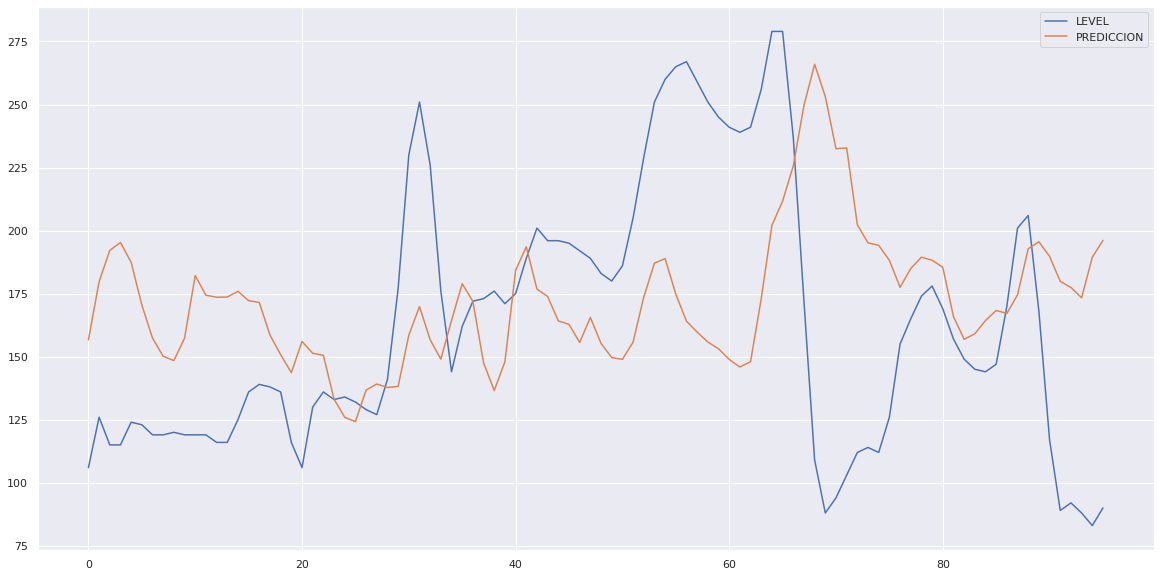

In [186]:
fig, ax1 = plt.subplots(nrows = 1, figsize=(20,10))   
predicciones_MLP.iloc[:96,:].plot(kind = 'line', ax=  ax1);

### Desescalado

In [187]:
predicciones_MLP['medias'] = vect_medias_test_diaria
predicciones_MLP['std'] = vect_desvt_test_diaria
predicciones_MLP['LEVEL_REAL'] = df_test['LEVEL']
predicciones_MLP.head()

,LEVEL,PREDICCION,medias,std,LEVEL_REAL
0,106.0,156.656104,149.750000,48.197943,141.0
1,126.0,179.724869,149.041667,48.817030,107.0
2,115.0,192.151969,149.031250,48.826106,77.0
3,115.0,195.269517,149.541667,48.323975,63.0
4,124.0,187.437525,150.083333,47.637447,53.0


In [188]:
### CALCULAMOS EL ERROR DE LA SERIE

In [196]:
mean_absolute_error(predicciones_MLP['LEVEL'], predicciones_MLP['LEVEL_REAL'])

79.91311726705354

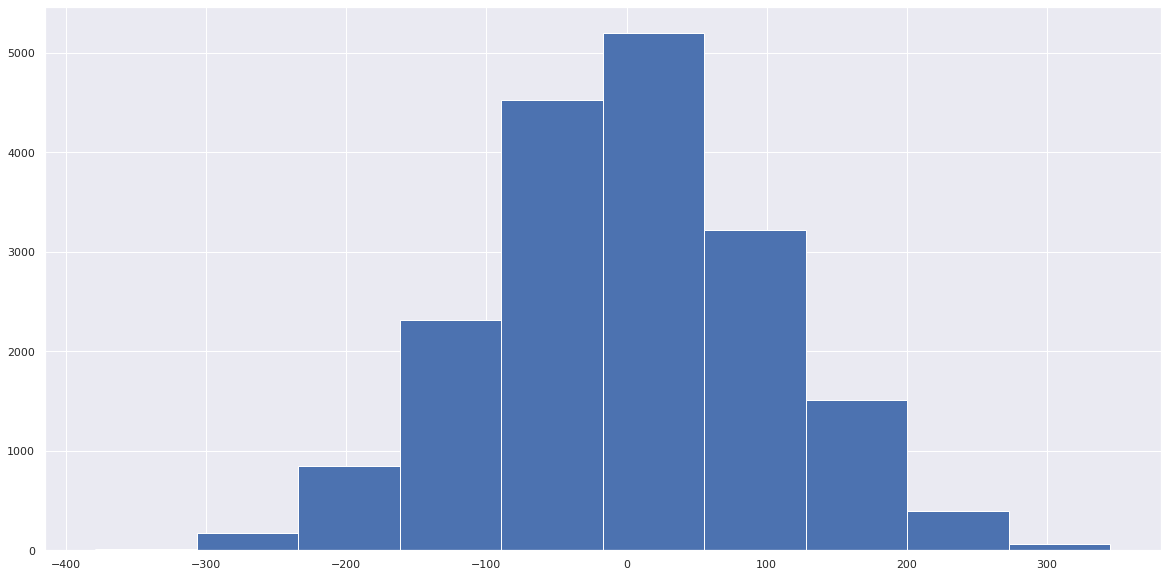

In [198]:
predicciones_MLP['ERROR'] = predicciones_MLP['LEVEL'] - predicciones_MLP['LEVEL_REAL']

#creamos el histograma de dsitribucion de los errores
plt.figure(figsize = (20,10))
predicciones_MLP['ERROR'].hist()                                                       

In [199]:
perc_90 = np.percentile(predicciones_MLP['ERROR'], 90)
perc_90

132.0

### Semanal

In [200]:
mlp_train_pred_semanal = ts_model_semanal.predict(X_train_scaled_semanal)
mlp_test_pred_semanal = ts_model_semanal.predict(X_test_scaled_semanal)
print('Train mae:', mean_absolute_error(y_train_scaled_semanal, mlp_train_pred_semanal))
print('Validation mae:', mean_absolute_error(y_test_scaled_semanal, mlp_test_pred_semanal))

Train mae: 0.9477730234688687
Validation mae: 0.9551644169716491


In [201]:
predicciones_MLP_semanal = pd.DataFrame({'LEVEL':y_test_scaled_semanal.flatten(), 'PREDICCION':mlp_test_pred_semanal.flatten()})

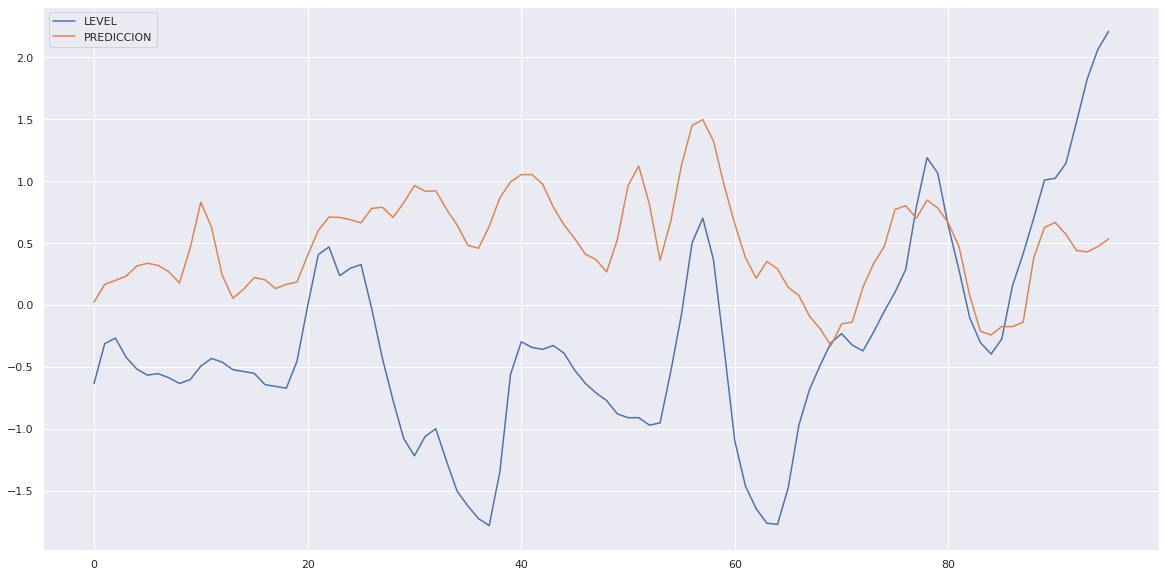

In [202]:
fig, ax1 = plt.subplots(nrows = 1, figsize=(20,10))   
predicciones_MLP_semanal.iloc[:96,:].plot(kind = 'line', ax=  ax1);

### DESESCALADO

In [205]:
predicciones_MLP_semanal['medias'] = vect_medias_test_semanal
predicciones_MLP_semanal['std'] = vect_desvt_test_semanal
predicciones_MLP_semanal['LEVEL_REAL'] = df_test['LEVEL']
predicciones_MLP_semanal.head()

,LEVEL,PREDICCION,medias,std,LEVEL_REAL
0,-0.634417,0.023160,170.495536,65.407377,141.0
1,-0.312669,0.166849,170.458333,65.431248,107.0
2,-0.267427,0.198292,170.491071,65.404988,77.0
3,-0.422594,0.233177,170.599702,65.310172,63.0
4,-0.517534,0.315108,170.733631,65.181538,53.0


In [206]:
#Realizamos la operacion de desescalado
predicciones_MLP_semanal['PRED_REAL'] = predicciones_MLP_semanal['PREDICCION'] * predicciones_MLP_semanal['std'] + predicciones_MLP_semanal['medias']
#Nos quedamos con las columnas que nos interesan
predicciones_semanales_reales = predicciones_MLP_semanal.drop(['LEVEL','PREDICCION', 'medias', 'std'], axis = 1)

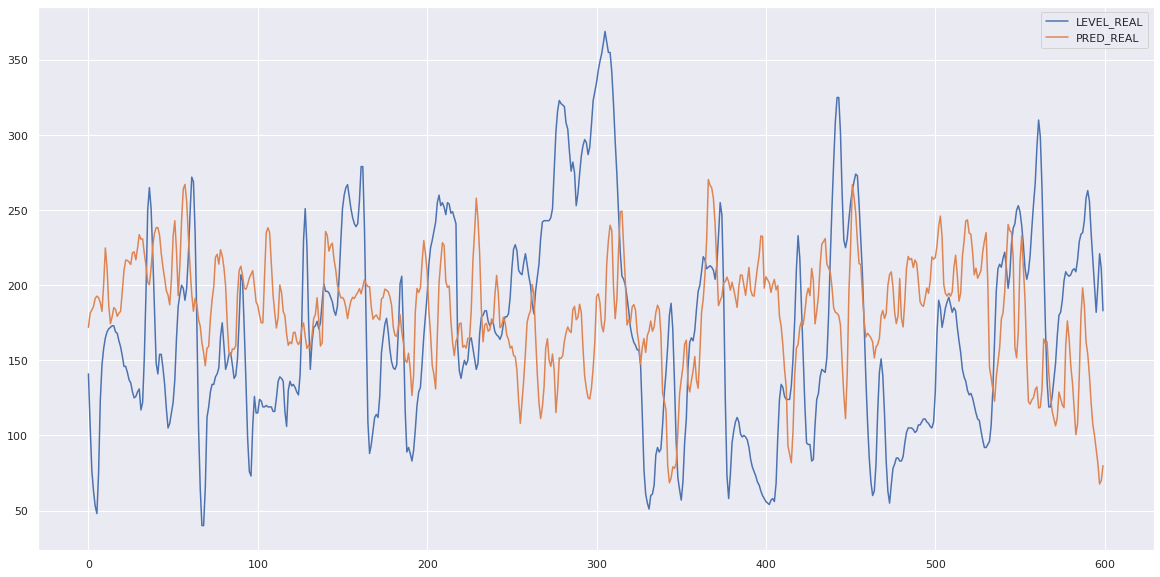

In [207]:
fig, ax1 = plt.subplots(nrows = 1, figsize=(20,10))   
predicciones_semanales_reales.iloc[:600,:].plot(kind = 'line', ax=  ax1);

In [208]:
mean_absolute_error(predicciones_semanales_reales['LEVEL_REAL'], predicciones_semanales_reales['PRED_REAL'])

69.45147427956724

In [209]:
predicciones_semanales_reales['ERROR'] = predicciones_semanales_reales['LEVEL_REAL'] - predicciones_semanales_reales['PRED_REAL']




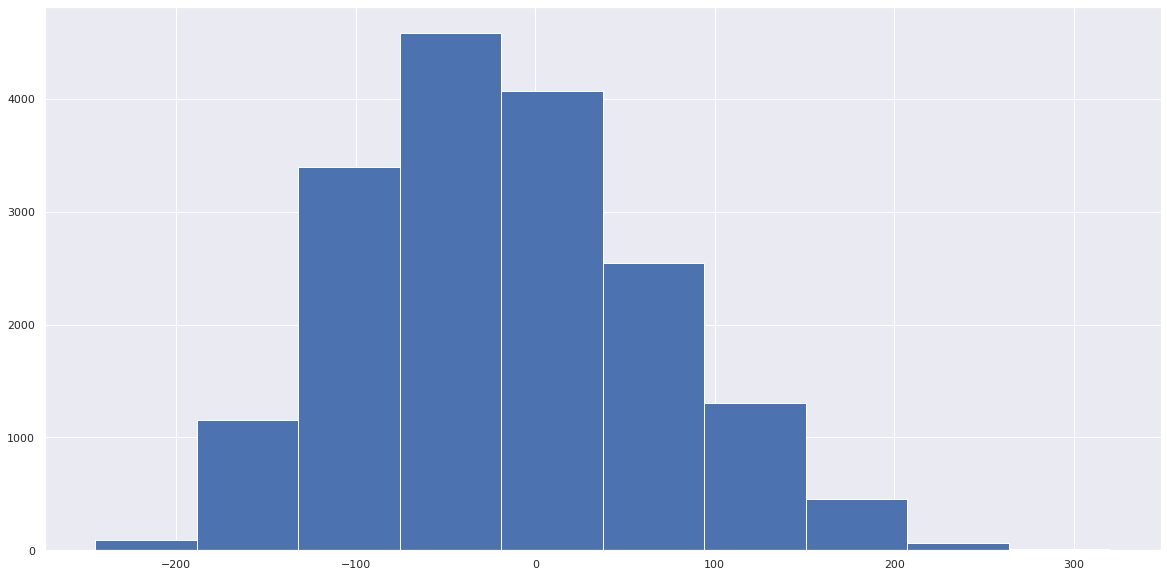

In [210]:
plt.figure(figsize = (20,10))
predicciones_semanales_reales['ERROR'].hist()

In [211]:
perc_90 = np.percentile(predicciones_semanales_reales['ERROR'], 90)
perc_90

95.94030038212064

## 5. Red Neuronal LSTM
<a id="5"></a>

In [212]:
print('Shape of train arrays:', X_train_semanal.shape, y_train_semanal.shape)
print('Shape of validation arrays:', X_test_semanal.shape, y_test_semanal.shape) 

Shape of train arrays: (74621, 672) (74621, 1)
Shape of validation arrays: (17690, 672) (17690, 1)


In [213]:
#X_train and X_val are reshaped to 3D arrays
X_train_semanal_LSTM, X_test_semanal_LSTM = X_train_scaled_semanal.reshape((X_train_scaled_semanal.shape[0], X_train_scaled_semanal.shape[1], 1)), X_test_scaled_semanal.reshape((X_test_scaled_semanal.shape[0], X_test_scaled_semanal.shape[1], 1))
print('Shape of arrays after reshaping:', X_train_semanal_LSTM.shape, X_test_semanal_LSTM.shape)

Shape of arrays after reshaping: (74621, 672, 1) (17690, 672, 1)


### 5.1 Modelo
<a id="5.1"></a>

In [214]:
from keras.layers import Dense, Input, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [215]:
input_layer = Input(shape=(x_window_size_semanal,1), dtype='float32')

#LSTM layer is defined 
lstm_layer = LSTM(100, input_shape=(x_window_size_semanal,1), return_sequences=False)(input_layer)

dropout_layer = Dropout(0.2)(lstm_layer)

#Finally the output layer gives prediction 
output_layer = Dense(y_window_size_semanal, activation='linear')(dropout_layer)

In [216]:
import keras.metrics

ts_model_LSTM = Model(inputs=input_layer, outputs=output_layer)
ts_model_LSTM.compile(loss='mean_absolute_error', optimizer='adam', metrics=[keras.metrics.MeanAbsoluteError()])
ts_model_LSTM.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 672, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [217]:
# guardar el modelo
ts_model_LSTM.save("modelos_paciente_0_LSTM")

INFO:tensorflow:Assets written to: modelos_paciente_0_LSTM/assets


In [218]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
from os.path import isfile, join
from os import getcwd

save_weights_at = join(getcwd(), 'modelos_paciente_0_LSTM')
save_best = ModelCheckpoint('/gdrive/My Drive/modelos/modelos_paciente_0_LSTM', monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            save_freq=1)
ts_model_LSTM.fit(x=X_train_semanal_LSTM, y=y_train_scaled_semanal, batch_size=3000, epochs=1000,
             verbose=1, callbacks=[save_best], validation_data=(X_test_semanal_LSTM, y_test_scaled_semanal),
             shuffle=True)

In [220]:
with open('/gdrive/My Drive/modelos_paciente_0_LSTM', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/My Drive/modelos_paciente_0_LSTM'

Hello Google Drive!

### 5.2 Predicciones
<a id="5.2"></a>

In [221]:
#carga el modelpo anteiror
from keras.models import load_model
ts_model_LSTM = load_model("modelos_paciente_0_LSTM")

In [222]:
from sklearn.metrics import mean_absolute_error

In [223]:
mlp_train_pred_scaled_semanal = ts_model_LSTM.predict(X_train_scaled_semanal)
mlp_test_pred_scaled_semanal = ts_model_LSTM.predict(X_test_scaled_semanal)
print('Train mae:', mean_absolute_error(y_train_scaled_semanal, mlp_train_pred_scaled_semanal))
print('Test mae:', mean_absolute_error(y_test_scaled_semanal, mlp_test_pred_scaled_semanal))

Train mae: 0.8847717689884199
Test mae: 0.8895928701805589


**Visualizacion**

In [224]:
lista_test_semanal_LSTM = [] 
for i in range(len(y_test_scaled_semanal)):
  test_error = y_test_scaled_semanal[i][0] 
  lista_test_semanal_LSTM.append(test_error)

In [226]:
lista_prediccion_semanal_LSTM = [] 
for i in range(len(mlp_test_pred_scaled_semanal)):
  prediccion_error = mlp_test_pred_scaled_semanal[i][0] 
  lista_prediccion_semanal_LSTM.append(prediccion_error)

In [227]:
predicciones = pd.DataFrame({'LEVEL':lista_test_semanal_LSTM, 'PREDICCION':lista_prediccion_semanal_LSTM})

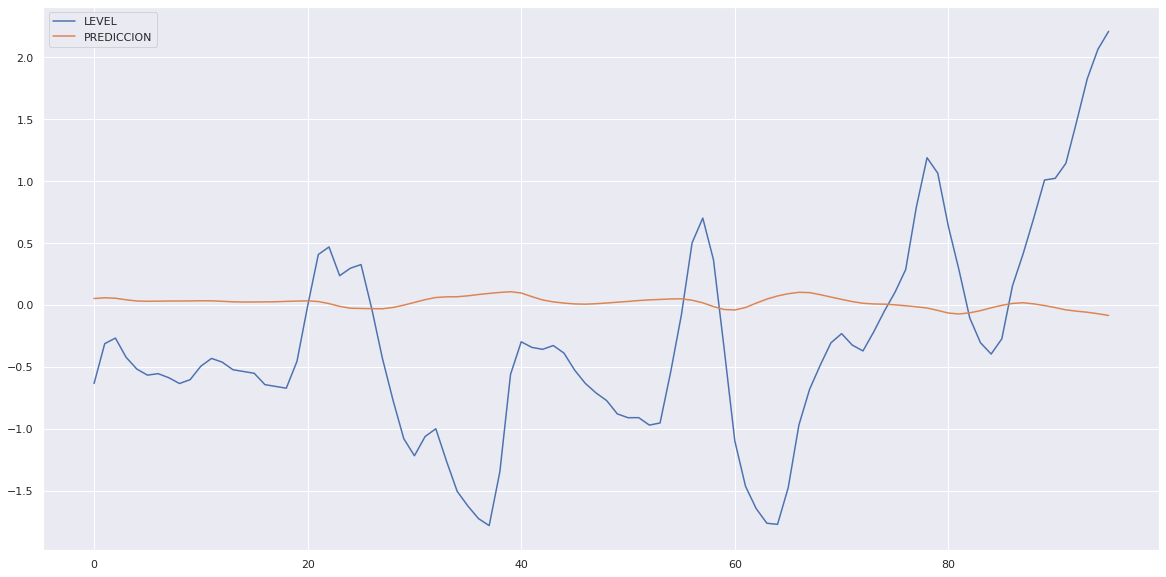

In [228]:
fig, ax1 = plt.subplots(nrows = 1, figsize=(20,10))   
predicciones.iloc[:96,:].plot(kind = 'line', ax=  ax1);

### Desescalado

In [229]:
predicciones['medias'] = vect_medias_test_semanal
predicciones['std'] = vect_desvt_test_semanal
predicciones['LEVEL_REAL'] = df_test['LEVEL']
predicciones.head()

,LEVEL,PREDICCION,medias,std,LEVEL_REAL
0,-0.634417,0.052060,170.495536,65.407377,141.0
1,-0.312669,0.057875,170.458333,65.431248,107.0
2,-0.267427,0.054490,170.491071,65.404988,77.0
3,-0.422594,0.041991,170.599702,65.310172,63.0
4,-0.517534,0.032134,170.733631,65.181538,53.0


In [230]:
predicciones['PRED_REAL'] = predicciones['PREDICCION'] * predicciones['std'] + predicciones['medias']
predicciones.head()

,LEVEL,PREDICCION,medias,std,LEVEL_REAL,PRED_REAL
0,-0.634417,0.052060,170.495536,65.407377,141.0,173.900638
1,-0.312669,0.057875,170.458333,65.431248,107.0,174.245188
2,-0.267427,0.054490,170.491071,65.404988,77.0,174.054973
3,-0.422594,0.041991,170.599702,65.310172,63.0,173.342133
4,-0.517534,0.032134,170.733631,65.181538,53.0,172.828207


In [231]:
predicciones_reales = predicciones.drop(['LEVEL','PREDICCION', 'medias', 'std'], axis = 1)
predicciones_reales.head()

,LEVEL_REAL,PRED_REAL
0,141.0,173.900638
1,107.0,174.245188
2,77.0,174.054973
3,63.0,173.342133
4,53.0,172.828207


In [232]:
pred_LEVEL = np.squeeze(predicciones_reales['PRED_REAL'])

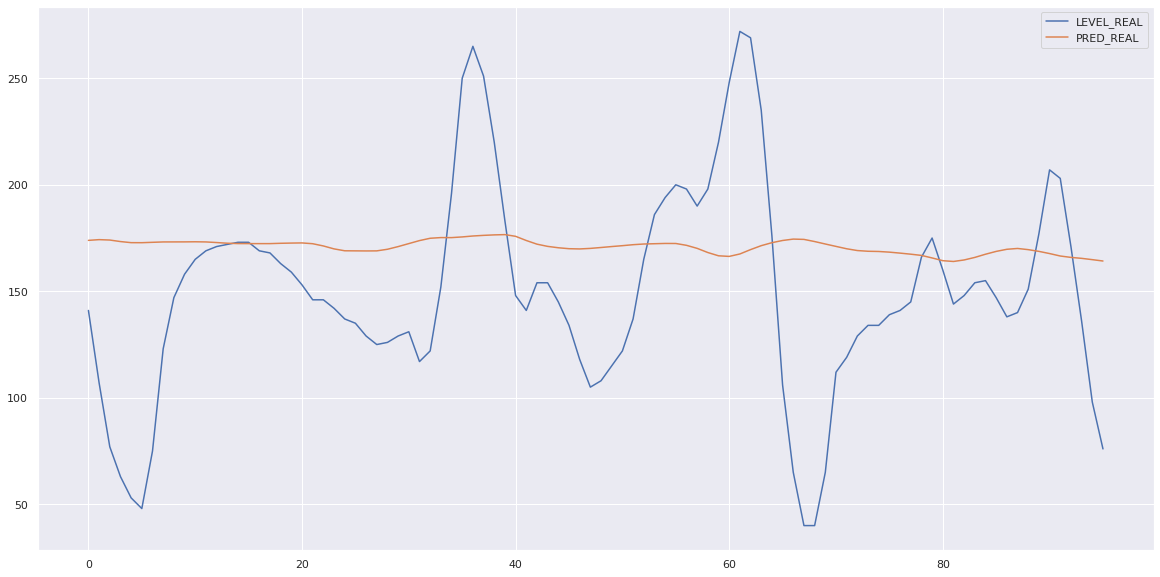

In [234]:
fig, ax1 = plt.subplots(nrows = 1, figsize=(20,10))   
predicciones_reales.iloc[:96,:].plot(kind = 'line', ax=  ax1);

### MAE

In [235]:
#Calculo del error
mean_absolute_error(predicciones_reales['LEVEL_REAL'], predicciones_reales['PRED_REAL'])

59.71817253710099

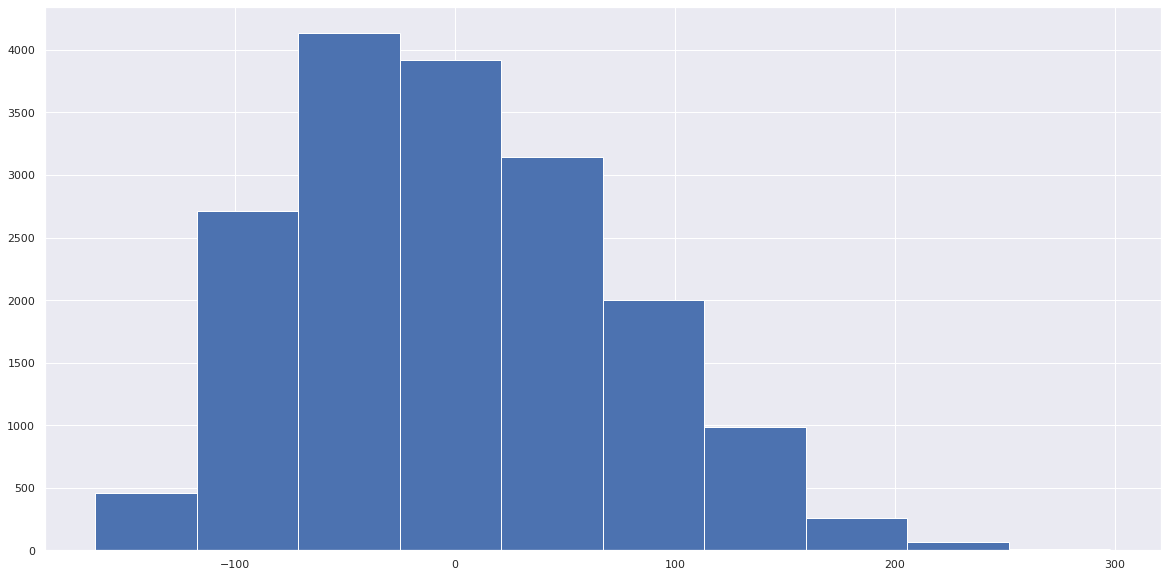

In [237]:
##Vemos como se distribuye el error 

predicciones_reales['ERROR'] = predicciones_reales['LEVEL_REAL'] - predicciones_reales['PRED_REAL']

plt.figure(figsize = (20,10))
predicciones_reales['ERROR'].hist()

In [238]:
perc_90 = np.percentile(predicciones_reales['ERROR'], 90)
perc_90

100.61887857873876

## 6. Red Neuronal Convolucional
<a id="6"></a>

### 6.1 Modelo
<a id="6.1"></a>

In [239]:
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import ZeroPadding1D
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import AveragePooling1D
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [240]:
#X_train and X_val are reshaped to 3D arrays
X_train_scaled_semanal_CONV, X_test_scaled_semanal_CONV = X_train_scaled_semanal.reshape((X_train_scaled_semanal.shape[0], X_train_scaled_semanal.shape[1], 1)), X_test_scaled_semanal.reshape((X_test_scaled_semanal.shape[0], X_test_scaled_semanal.shape[1], 1))
print('Shape of arrays after reshaping:', X_train_scaled_semanal_CONV.shape, X_test_scaled_semanal_CONV.shape)

Shape of arrays after reshaping: (74621, 672, 1) (17690, 672, 1)


In [241]:
#Define input layer 
input_layer = Input(shape=(x_window_size_semanal,1), dtype='float32')

#Add zero padding
zeropadding_layer = ZeroPadding1D(padding=1)(input_layer)

#Add 1D convolution layers
conv1D_layer1 = Conv1D(64, 4, strides=1, use_bias=True)(zeropadding_layer)
conv1D_layer2 = Conv1D(32, 4, strides=1, use_bias=True)(conv1D_layer1)

#Add AveragePooling1D layer
avgpooling_layer = AveragePooling1D(pool_size=3, strides=1)(conv1D_layer2)

#Add Flatten layer
flatten_layer = Flatten()(avgpooling_layer)

#A couple of Dense layers are also added
dense_layer1 = Dense(32)(avgpooling_layer)
dense_layer2 = Dense(16)(dense_layer1)

dropout_layer = Dropout(0.2)(flatten_layer)

#Finally the output layer gives prediction 
output_layer = Dense(y_window_size_semanal, activation='linear')(dropout_layer)

In [242]:
import keras.metrics

ts_model_CONV = Model(inputs=input_layer, outputs=output_layer)
ts_model_CONV.compile(loss='mean_absolute_error', optimizer='adam', metrics=[keras.metrics.MeanAbsoluteError()])
ts_model_CONV.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 672, 1)]          0         
_________________________________________________________________
zero_padding1d (ZeroPadding1 (None, 674, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 671, 64)           320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 668, 32)           8224      
_________________________________________________________________
average_pooling1d (AveragePo (None, 666, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 21312)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 21312)           

In [243]:
# guardar el modelo
ts_model_CONV.save("modelos_paciente_0_CONV_1D")

INFO:tensorflow:Assets written to: modelos_paciente_0_CONV_1D/assets


In [ ]:
from os.path import isfile, join
from os import getcwd

save_weights_at = join(getcwd(), 'modelos_paciente_0_CONV_1D')
save_best = ModelCheckpoint('/gdrive/My Drive/modelos/modelos_paciente_0_CONV_1D', monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)
ts_model_CONV.fit(x=X_train_scaled_semanal_CONV, y=y_train_scaled_semanal, batch_size=3000, epochs=1000,
             verbose=1, callbacks=[save_best], validation_data=(X_test_scaled_semanal_CONV, y_test_scaled_semanal),
             shuffle=True)

In [244]:
#carga el modelpo anteiror
from keras.models import load_model
ts_model_CONV = load_model("modelos_paciente_0_CONV_1D")

### 6.2 Predicciones
<a id="6.2"></a>

In [245]:
CONV_train_pred_scaled_semanal = ts_model_CONV.predict(X_train_scaled_semanal)
CONV_test_pred_scaled_semanal = ts_model_CONV.predict(X_test_scaled_semanal)
print('Train mae:', mean_absolute_error(y_train_scaled_semanal, CONV_train_pred_scaled_semanal))
print('Test mae:', mean_absolute_error(y_test_scaled_semanal, CONV_test_pred_scaled_semanal))

Train mae: 0.8561001254681577
Test mae: 0.8672382738341898


In [246]:
lista_test_semanal_CONV = [] 
for i in range(len(y_test_scaled_semanal)):
  test_error = y_test_scaled_semanal[i][0] 
  lista_test_semanal_CONV.append(test_error)

In [247]:
lista_prediccion_semanal_CONV = [] 
for i in range(len(CONV_test_pred_scaled_semanal)):
  prediccion_error = CONV_test_pred_scaled_semanal[i][0] 
  lista_prediccion_semanal_CONV.append(prediccion_error)

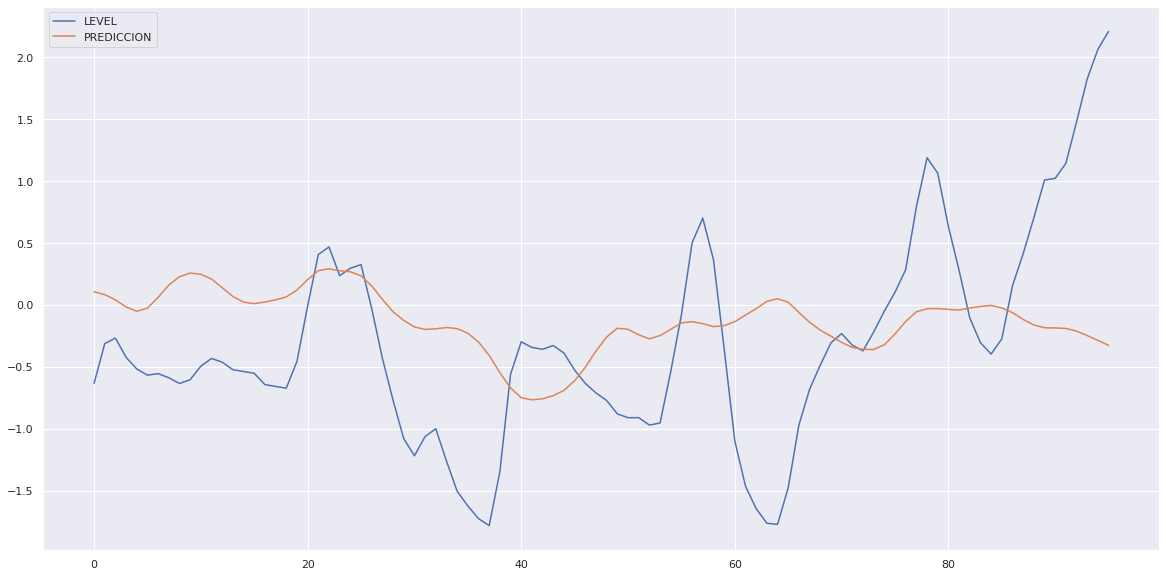

In [249]:
predicciones_CONV = pd.DataFrame({'LEVEL':lista_test_semanal_CONV, 'PREDICCION':lista_prediccion_semanal_CONV})

#GENERAMOS EL PLOT

fig, ax1 = plt.subplots(nrows = 1, figsize=(20,10))   
predicciones_CONV.iloc[:96,:].plot(kind = 'line', ax=  ax1);

### DESESCALAMOS LOS DATOS


In [250]:
predicciones_CONV['medias'] = vect_medias_test_semanal
predicciones_CONV['std'] = vect_desvt_test_semanal
predicciones_CONV['LEVEL_REAL'] = df_test['LEVEL']
predicciones_CONV.head()

,LEVEL,PREDICCION,medias,std,LEVEL_REAL
0,-0.634417,0.106940,170.495536,65.407377,141.0
1,-0.312669,0.083600,170.458333,65.431248,107.0
2,-0.267427,0.041142,170.491071,65.404988,77.0
3,-0.422594,-0.016494,170.599702,65.310172,63.0
4,-0.517534,-0.050938,170.733631,65.181538,53.0


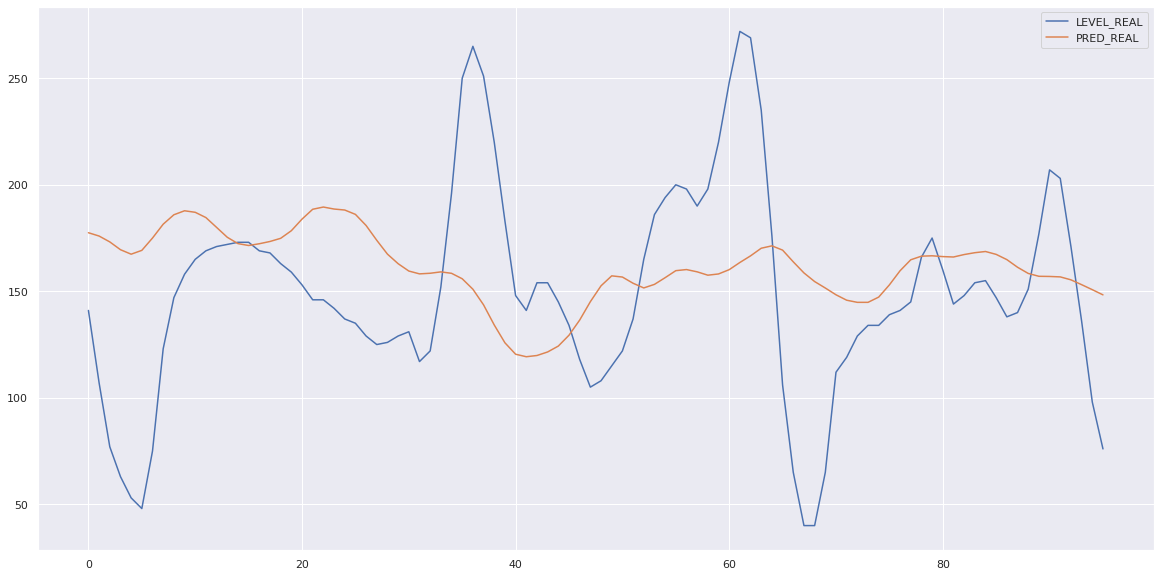

In [251]:
predicciones_CONV['PRED_REAL'] = predicciones_CONV['PREDICCION'] * predicciones_CONV['std'] + predicciones_CONV['medias']

predicciones_reales_CONV = predicciones_CONV.drop(['LEVEL','PREDICCION', 'medias', 'std'], axis = 1)

fig, ax1 = plt.subplots(nrows = 1, figsize=(20,10))   
predicciones_reales_CONV.iloc[:96,:].plot(kind = 'line', ax=  ax1);

In [252]:
predicciones_reales_CONV.head()

,LEVEL_REAL,PRED_REAL
0,141.0,177.490173
1,107.0,175.928360
2,77.0,173.181933
3,63.0,169.522502
4,53.0,167.413430


### MAE

In [253]:
mean_absolute_error(predicciones_reales_CONV['LEVEL_REAL'], predicciones_reales_CONV['PRED_REAL'])

60.98727154156044

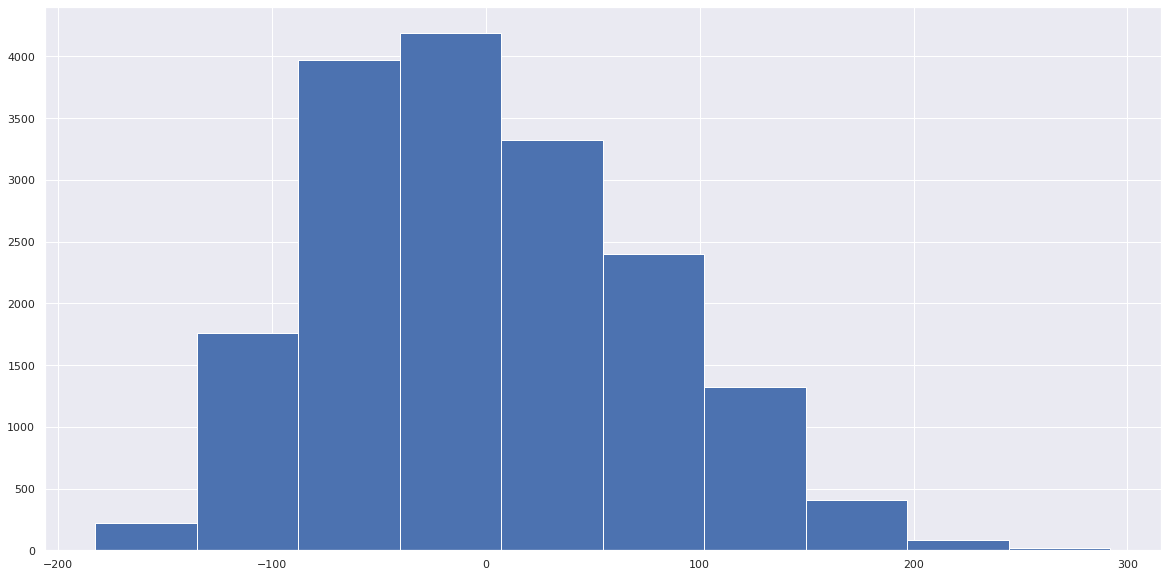

In [254]:
predicciones_reales_CONV['ERROR'] = predicciones_reales_CONV['LEVEL_REAL'] - predicciones_reales_CONV['PRED_REAL']

plt.figure(figsize = (20,10))
predicciones_reales_CONV['ERROR'].hist()

In [255]:
perc_90 = np.percentile(predicciones_reales_CONV['ERROR'], 90)
perc_90

103.44503158131604